In [5]:
import pandas as pd
import numpy as np
import pickle
from keras.models import Model, Sequential
# from keras.applications import resnet50, vgg16, densenet
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, KFold
from keras import backend as K
from keras.layers import *
from keras import layers
import keras
from keras.callbacks import EarlyStopping, Callback
# from skimage.io import imread
import sklearn
import lightgbm as lgb
from matplotlib import pyplot
K.set_image_data_format('channels_last')

path = '../Data/'

# class_emb = pd.read_csv(path + '/DatasetA_train_20180813/class_wordembeddings.txt', 
#                         index_col = 0, sep = ' ', header = None)
# class_emb.index.name = 'class_name'
# # class_emb_vec = pd.DataFrame(index = class_emb.index)
# class_emb = class_emb.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_to_name = pd.read_csv(path + '/DatasetA_train_20180813/label_list.txt', 
#                                index_col = 'class_name', sep = '\t', header = None, names = ['class_id', 'class_name'])

# attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)

# attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
#                                    index_col = 0, sep = '\t', header = None)
# attributes_per_class.index.name = 'class_id'
# attributes_per_class = attributes_per_class.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

# class_id_emb_attr = class_id_to_name.copy()
# class_id_emb_attr['emb'] = class_emb
# class_id_emb_attr.reset_index(inplace = True)
# class_id_emb_attr.set_index('class_id', inplace = True)
# class_id_emb_attr['attr'] = attributes_per_class

# with open(path + 'class_id_emb_attr.pickle', 'wb+') as handle:
#     pickle.dump(class_id_emb_attr, handle)

In [3]:
# train_data = pd.read_csv(path + '/DatasetA_train_20180813/train.txt', index_col = 'class_id', 
#                          sep = '\t', header = None, names = ['image_id', 'class_id'])
# train_data = train_data.merge(class_id_emb_attr, how = 'left', on = 'class_id')

# imag_path = path + r'/DatasetA_train_20180813/train/'
# def read_image(image_id):
#     img = image.load_img(imag_path + image_id)
#     img = image.img_to_array(img)
# #     img= vgg16.preprocess_input(image.img_to_array(img))
#     return img
# train_data['img'] = train_data['image_id'].apply(lambda id: read_image(id))

# train_data.reset_index(inplace = True)
with open(path + 'class_id_emb_attr.pickle', 'rb') as handle:
    class_id_emb_attr = pickle.load(handle)
    
with open(path + 'train_img.pickle', 'rb') as handle:
    train_data = pickle.load(handle)

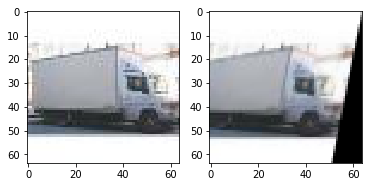

In [39]:
from skimage import io
from skimage import transform

img = train_data.iloc[5000].img / 255

afine_tf = transform.AffineTransform(shear=-0.2)

# Apply transform to image data
modified = transform.warp(img, inverse_map=afine_tf)

# Display the result
# io.imshow(modified)
# io.imshow(img)
pyplot.subplot(121)
pyplot.imshow(img)
pyplot.subplot(122)
pyplot.imshow(modified)

In [14]:
train_data.iloc[2].img

array([[[ 81.,  69.,  21.],
        [ 86.,  74.,  26.],
        [ 85.,  75.,  26.],
        ...,
        [ 78.,  81.,  38.],
        [ 97., 100.,  57.],
        [130., 133.,  90.]],

       [[ 90.,  79.,  51.],
        [ 89.,  78.,  50.],
        [ 84.,  72.,  46.],
        ...,
        [ 75.,  75.,  49.],
        [104., 104.,  76.],
        [121., 120.,  92.]],

       [[ 76.,  66.,  57.],
        [ 69.,  60.,  51.],
        [ 60.,  51.,  44.],
        ...,
        [ 99.,  96.,  87.],
        [ 76.,  73.,  64.],
        [ 53.,  49.,  40.]],

       ...,

       [[ 15.,  21.,  19.],
        [ 25.,  34.,  31.],
        [ 27.,  39.,  35.],
        ...,
        [ 26.,  30.,  13.],
        [ 11.,   9.,   0.],
        [ 11.,   4.,   0.]],

       [[ 53.,  55.,  54.],
        [ 37.,  41.,  40.],
        [ 36.,  42.,  38.],
        ...,
        [  2.,  10.,   0.],
        [ 11.,  10.,   5.],
        [ 25.,  21.,  18.]],

       [[ 74.,  72.,  73.],
        [ 46.,  46.,  44.],
        [ 39.,  

In [7]:
category = train_data['class_id'].unique()
category_dict = dict((category[i], i) for i in range(category.shape[0]))

# vgg_model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = train_data['class_id'].unique().shape[0])


# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)

# input = Input(shape = (2048, ))
# dense = Dense(2048, activation="relu")(input)
# dense = Dropout(0.5)(dense)
# dense = Dense(2048, activation="relu")(input)
# dense = Dense(1024, activation="relu")(input)
# dense = Dense(category.shape[0], activation="softmax")(input)

# vgg_model = Model(input, dense)

# vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

# print (vgg_model.summary())

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)
# train_data['target'] = list(train_image_feature_map)

def small_vgg(img_input_shape, classes):
    # Block 1
    img_input = Input(shape = (img_input_shape))
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#     # Block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
#     # Block 3
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
#     # Block 4
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
#     # Block 5
#     x = layers.Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv1')(x)
#     x = layers.Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv2')(x)
#     x = layers.Conv2D(256, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv3')(x)
#     x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Classification block
    x = layers.Flatten(name='flatten')(x)
#     x = layers.Dense(1024, activation='relu', name='fc1')(x)
#     x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x)
    print (model.summary())
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    return model

def small_densenet(img_input_shape, classes, blocks = [6, 12, 24, 16]):
    img_input = Input(shape = (img_input_shape))
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(
        axis=3, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
    
    x = densenet.dense_block(x, blocks[0], name='conv2')
    x = densenet.transition_block(x, 0.5, name='pool2')
    x = densenet.dense_block(x, blocks[1], name='conv3')
    x = densenet.transition_block(x, 0.5, name='pool3')
    x = densenet.dense_block(x, blocks[2], name='conv4')
    x = densenet.transition_block(x, 0.5, name='pool4')
    x = densenet.dense_block(x, blocks[3], name='conv5')
    
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc')(x)
    
    model = Model(img_input, x)
    print (model.summary())
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    return model

train_img = extract_array_from_series(train_data['img'])
train_img = vgg16.preprocess_input(train_img)
OneHotEncoder = sklearn.preprocessing.OneHotEncoder()
train_target = train_data['class_id'].apply(lambda id: category_dict[id]).values
train_target = OneHotEncoder.fit_transform(np.reshape(train_target, (-1, 1))).toarray()

In [9]:
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(train_img):
    train_part_img = train_img[train_index]
    validate_part_img = train_img[test_index]
    
    train_part_target = train_target[train_index]
    validate_part_target = train_target[test_index]
    
    print ('Train target nunique: ', np.unique(np.argwhere(train_part_target == 1)[:, 1]).shape[0], 
           'Validate target nuique: ', np.unique(np.argwhere(validate_part_target == 1)[:, 1]).shape[0])
#     model = vgg16.VGG16(include_top=True, weights = None, input_shape=(64, 64, 3), classes = category.shape[0])
#     model = resnet50.ResNet50(include_top=True, weights = None, input_shape=(224, 224, 3), classes = category.shape[0])
#     print (model.summary())
#     model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
    img_model = small_densenet(blocks = [2, 2, 2, 2], img_input_shape=(64, 64, 3), classes = train_target.shape[1]) 
#     print (img_model.summary())
    # img_model = small_vgg(img_input_shape = (64, 64, 3), classes = train_target.shape[1])
    h = img_model.fit(train_part_img, train_part_target, validation_data=(validate_part_img, validate_part_target), 
                  epochs=10, batch_size = 64, shuffle=True, verbose = 1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0)])
    break

Train target nunique:  190 Validate target nuique:  190
Train on 30576 samples, validate on 7645 samples
Epoch 1/10
30576/30576 [==============================] - 646s 21ms/step - loss: 3.7635 - categorical_accuracy: 0.1645 - val_loss: 3.9950 - val_categorical_accuracy: 0.1440
Epoch 2/10
30576/30576 [==============================] - 656s 21ms/step - loss: 3.5163 - categorical_accuracy: 0.2014 - val_loss: 3.5633 - val_categorical_accuracy: 0.1996
Epoch 3/10
30576/30576 [==============================] - 658s 22ms/step - loss: 3.3222 - categorical_accuracy: 0.2366 - val_loss: 3.5310 - val_categorical_accuracy: 0.2114
Epoch 4/10
30576/30576 [==============================] - 652s 21ms/step - loss: 3.1632 - categorical_accuracy: 0.2608 - val_loss: 3.5205 - val_categorical_accuracy: 0.2126
Epoch 5/10
30576/30576 [==============================] - 653s 21ms/step - loss: 3.0152 - categorical_accuracy: 0.2864 - val_loss: 3.4801 - val_categorical_accuracy: 0.2275
Epoch 6/10
30576/30576 [======

In [50]:
# df = pd.DataFrame(h.history)
# df = df.append(df)
# df.groupby(df.index).agg({'mean', 'max', 'median'})
# h.epoch
# x = pd.DataFrame()
# x.append(df)
train_img.shape

(38221, 64, 64, 3)

In [186]:
# np.asarray(list(train_data['img'])).shape
# train_data[train_data['class_id'] == 'ZJL1']
# train_data['class_id'].value_counts().hist()
# train_data.head()
# class_id_emb_attr.iloc[0].name
# resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
img = image.load_img(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg', target_size=(224, 224))
img = image.img_to_array(img)
img = vgg16.preprocess_input(img)
preds = vgg_model.predict(np.expand_dims(img, axis=0))
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])
# imread(path + '/DatasetA_train_20180813/train/000c0d617f5b67d116dee15c40d1d47d.jpeg')
# image.img_to_array(img).shape

Predicted: [('n03598930', 'jigsaw_puzzle', 0.023861792), ('n02095314', 'wire-haired_fox_terrier', 0.022931756), ('n04589890', 'window_screen', 0.021361042)]


In [15]:
def full_connect_layer(input, hidden_dim):
    full_connect = input
    for hn in hidden_dim:
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
        #     full_connect = Dropout(self.full_connect_dropout)(full_connect)
        # full_connect = BatchNormalization()(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
        full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
            Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        # full_connect = Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
        #     full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
        full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def create_dnn():
    alpha = 0.03
    attr_input = Input(shape = (30,))
    word_emb = Input(shape = (300,))
    imag_classifier = Input(shape = (1024,))

    attr_dense = Dense(64, use_bias = False)(attr_input)
#     attr_dense = Dense(512)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(256)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(300, activation="relu")(attr_dense)
    # attr_dense = Dense(512, activation="relu")(attr_dense)

    attr_word_emb = Concatenate()([word_emb, attr_dense])
    attr_word_emb_dense = full_connect_layer(attr_word_emb, hidden_dim = [2048, 2048])
    attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(512)(attr_word_emb_dense)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(256)(attr_word_emb_dense)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(128)(attr_word_emb_dense)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(2048, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(512, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
    # attr_word_emb_dense = Dense(2048, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01))(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(2048, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(8192, activation="relu")(attr_word_emb_dense)

    # mse = Dense(6, activation="softmax")(dense_output)
#     vgg_input = vgg_model.input
#     vgg_output = Flatten()(vgg_model.output)
#     vgg_output = Dense(1024, activation="sigmoid")(vgg_output)

    # mse_loss = keras.losses.mean_squared_error(vgg_output, attr_word_emb_dense)

    model = Model([attr_input, word_emb], outputs = attr_word_emb_dense) #, vgg_output])
    # model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss='mean_squared_error')
#     model.summary()
    return model

def find_nearest_class(class_id_emb_attr, model, eval_df, img_feature_map = None):
    if img_feature_map is None:
        img_feature_map = np.reshape(vgg_model.predict(np.asarray(list(eval_df['img'])), verbose = 1), (eval_img.shape[0], -1))
    cand_feature_map = model.predict(create_dnn_data(class_id_emb_attr))
    # img_feature_map = np.repeat(img_feature_map, [cand_feature_map.shape[0]] * img_feature_map.shape[0], axis = 0)
    nearest_class_id = ['ZJL'] * eval_df.shape[0]
    for i in range(img_feature_map.shape[0]):
        img = img_feature_map[i]
        dis = np.linalg.norm(img - cand_feature_map, axis = 1)
        min_ind = np.where(dis == np.amin(dis))[0]
        if len(min_ind) > 1:
            print ('eval img id: ', eval_df.iloc[i]['class_id'], 'has multiple best candidates: ', len(min_ind), 'min val: ', np.amin(dis))
#         print (i, img, class_id_emb_attr.iloc[min_ind[0]].name)
        nearest_class_id[i] = class_id_emb_attr.iloc[min_ind[0]].name
#     print (nearest_class_id)
    return np.asarray(nearest_class_id)
    
    
def extract_array_from_series(s):
    return np.asarray(list(s))
    
def create_dnn_data(df):
    return [extract_array_from_series(df['attr']), extract_array_from_series(df['emb'])]
    
class AccuracyEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = [], class_id_emb_attr = None, eval_df = None):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores
        self.class_id_emb_attr = class_id_emb_attr
        self.eval_df = eval_df
#         self.img_feature_map = self.y_val

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            pred_nearest_class_id = find_nearest_class(self.class_id_emb_attr, self.model, self.eval_df, self.y_val)
            true_class_id = self.eval_df['class_id'].values
#             print (pred_nearest_class_id, "\n", true_class_id)
            right_num = np.sum(pred_nearest_class_id == true_class_id)
            score = right_num / true_class_id.shape[0]
            self.scores.append("epoch:{0} {1}".format(epoch + 1, score))
            print("\n Accuracy epoch: %d - score: %.6f \n %d/%d" % (epoch+1, score, right_num, true_class_id.shape[0]))
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)
            
def lgbm_train(train_part, train_part_label, valide_part, valide_part_label, fold_seed,
        fold = 5, train_weight = None, valide_weight = None, flags = None):
    """
    LGBM Training
    """
    print("-----LGBM training-----")

    d_train = lgb.Dataset(train_part, train_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = train_part[:, -1])
    d_valide = lgb.Dataset(valide_part, valide_part_label) #, categorical_feature = CATEGORY_FEATURES) #, init_score = valide_part[:, -1])
    params = {
            'task': 'train',
            'boosting_type': 'gbdt', #'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            # 'num_leaves':-1,
            'min_sum_hessian_in_leaf':None,
            'max_depth':7,
            'learning_rate':0.005,
            'feature_fraction':0.1,
            'verbose':-1,
            'num_boost_round':3000,
            'drop_rate':None,
            'bagging_fraction':0.6,
            'bagging_freq':5,
            'early_stopping_round':100,
            # 'min_data_in_leaf':100,
            'max_bin': None,
            'scale_pos_weight':None,
        }
    print ("lightgbm params: {0}\n".format(params))

    bst = lgb.train(
                    params ,
                    d_train,
                    verbose_eval = 200,
                    valid_sets = [d_train, d_valide],
                    # feature_name= keras_train.DENSE_FEATURE_LIST,
                    #feval = gini_lgbm
                    #num_boost_round = 1
                    )
    #pred = model_eval(bst, 'l', valide_part)
    #print(pred[:10])
    #print(valide_part_label[:10])
    #print(valide_part[:10, -1])
    # exit(0)
    feature_imp = bst.feature_importance(importance_type = 'gain')
    sort_ind = np.argsort(feature_imp)[::-1]
    print (np.c_[np.array(FEATURE_LIST)[sort_ind], feature_imp[sort_ind]][:10])
    # print (np.array(keras_train.FEATURE_LIST)[np.argsort(feature_imp)])
    # exit(0)
    # cv_result = lgb.cv(params, d_train, nfold=fold) #, feval = gini_lgbm)
    # pd.DataFrame(cv_result).to_csv('cv_result', index = False)
    # exit(0)
    return bst

In [5]:
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)
# img_model_flat = Model(input = img_model.input, output = img_model.get_layer(name = 'avg_pool').output)
# train_data['target'] = list(train_y) #
# train_data['target'] = list(img_model_flat.predict(train_img, verbose = 1))
img_model_flat = pd.read_csv(path + 'model_sub/6_12_24_16_03252/sub_2018_09_07_14_53_24.csv')

In [13]:
img_model_flat.set_index('image_id', inplace = True)
train_data['target'] = img_model_flat.apply(lambda s: np.asarray(s.astype(float)), axis = 1).values

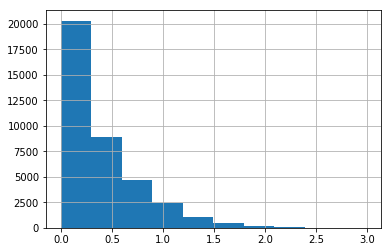

In [10]:
img_model_flat['1'].hist()

In [28]:
train_data.head()

,class_id,image_id,class_name,emb,attr,img,target
0,ZJL1,a6394b0f513290f4651cc46792e5ac86.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[20.0, 33.0, 7.0], [19.0, 32.0, 6.0], [22.0,...","[-0.11140289, 0.03374281, -0.52496225, 0.31107..."
1,ZJL1,2fb89ef2ace869d3eb3bdd3afe184e1c.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[140.0, 45.0, 51.0], [144.0, 47.0, 54.0], [1...","[-0.15818031, 0.21697168, -0.27058864, 0.10062..."
2,ZJL1,eda9f3bef2bd8da038f6acbc8355fc25.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[81.0, 69.0, 21.0], [86.0, 74.0, 26.0], [85....","[0.14246145, -0.100540064, 0.39058790000000004..."
3,ZJL1,7d93ef45972154aae150b4f9980a79c0.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[16.0, 14.0, 15.0], [18.0, 16.0, 17.0], [19....","[0.030461132999999998, -0.014244867, 0.0410932..."
4,ZJL1,fb901b4f9a8e396c1d0155bccc5e5671.jpeg,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ...","[[[120.0, 124.0, 127.0], [89.0, 93.0, 96.0], [...","[0.50596607, -0.44599533, 0.017522344, 0.51942..."


In [29]:
def full_connect_layer(input, hidden_dim):
    full_connect = input
    for hn in hidden_dim:
        fc_in = full_connect
        # if self.full_connect_dropout > 0:
        #     full_connect = Dropout(self.full_connect_dropout)(full_connect)
        full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
#         full_connect = Activation('relu')(full_connect)
        # full_connect = Dense(hn, kernel_regularizer = l2(0.001), activity_regularizer = l1(0.001))(full_connect)
#         full_connect = Concatenate()([Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect), 
#             Dense(hn, kernel_initializer='lecun_uniform', activation = 'sigmoid')(full_connect)])
        full_connect = Dense(hn, kernel_initializer='lecun_uniform', activation = 'relu')(full_connect)
#         full_connect = BatchNormalization(epsilon=1.001e-5)(full_connect)
#         full_connect = Activation('relu')(full_connect)
        # full_connect = self.act_blend(full_connect)
        # if self.full_connect_dropout > 0:
        #     full_connect = Dropout(self.full_connect_dropout)(full_connect) #Dropout(self.full_connect_dropout)(full_connect)
#         full_connect = Concatenate()([fc_in, full_connect])
    return full_connect

def create_dnn():
    alpha = 0.03
    attr_input = Input(shape = (30,))
    word_emb = Input(shape = (300,))
    imag_classifier = Input(shape = (1024,))

    attr_dense = Dense(32, use_bias = False)(attr_input)
#     attr_dense = Dense(512)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(256)(attr_dense)
#     attr_dense = LeakyReLU(alpha=alpha)(attr_dense)
#     attr_dense = Dense(300, activation="relu")(attr_dense)
    # attr_dense = Dense(512, activation="relu")(attr_dense)

    attr_word_emb = Concatenate()([word_emb, attr_dense])
    attr_word_emb_dense = full_connect_layer(attr_word_emb, hidden_dim = [2048, 1024, 1024])
    attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = attr_word_emb
#     attr_word_emb_dense = Dense(4096, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(1024)(attr_word_emb)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(512)(attr_word_emb_dense)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(256)(attr_word_emb_dense)
#     attr_word_emb_dense = LeakyReLU(alpha=alpha)(attr_word_emb_dense)
#     attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
#     attr_word_emb_dense = Dense(512, activation="relu")(attr_word_emb_dense)
#     attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
    # attr_word_emb_dense = Dense(2048, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01))(attr_word_emb_dense)


    # mse = Dense(6, activation="softmax")(dense_output)
#     vgg_input = vgg_model.input
#     vgg_output = Flatten()(vgg_model.output)
#     vgg_output = Dense(1024, activation="sigmoid")(vgg_output)

    # mse_loss = keras.losses.mean_squared_error(vgg_output, attr_word_emb_dense)

    model = Model([attr_input, word_emb], outputs = attr_word_emb_dense) #, vgg_output])
    # model.add_loss(mse_loss)
    model.compile(optimizer='adam', loss='mean_squared_error')
#     model.summary()
    return model

#data.loc[class_id] #data_atten.loc[n]
fold = 5
kf = KFold(n_splits=fold, shuffle=True)
num_fold = 0
class_ids = train_data['class_id'].unique() #[:5]

# train_image_feature_map = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1))
# with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
#     pickle.dump(train_y, handle)
# with open(path + 'train_vgg16_img_div255.pickle', 'rb') as handle:
#     train_image_feature_map = pickle.load(handle)

for train_index, test_index in kf.split(class_ids):
    train_part_id = class_ids[train_index]
    validate_part_id = class_ids[test_index]
    
    train_part_df = train_data[train_data['class_id'].isin(train_part_id)]
    validate_part_df = train_data[train_data['class_id'].isin(validate_part_id)]

    train_part_data = create_dnn_data(train_part_df)
    train_part_target = extract_array_from_series(train_part_df['target'])
    
    validate_part_data = create_dnn_data(validate_part_df)
    validate_part_target = extract_array_from_series(validate_part_df['target'])
    
    print('fold: %d th train :-)' % (num_fold))
    print('Train size: {} Valide size: {}'.format(train_part_df.shape[0], validate_part_df.shape[0]))
    print('Train category: {} Valide category: {}'.format(train_part_id.shape[0], validate_part_id.shape[0]))

    callbacks = [
            EarlyStopping(monitor='val_loss', patience=30, verbose=0),
            AccuracyEvaluation(validation_data=(validate_part_data, validate_part_target), interval=1, \
                class_id_emb_attr = class_id_emb_attr.loc[validate_part_id], eval_df = validate_part_df)
            ]
    
    model = create_dnn()
    if num_fold == 0:
        print (model.summary())
    model.fit(train_part_data, train_part_target,  validation_data=(validate_part_data, validate_part_target),
                  epochs=100, batch_size = 64, shuffle=True, verbose = 1, callbacks=callbacks)
    
#     model = lgbm_train(train_part_data[0], train_part_target, validate_part_data[0], validate_part_target, num_fold, fold)
    num_fold += 1

fold: 0 th train :-)
Train size: 30502 Valide size: 7719
Train category: 152 Valide category: 38
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 32)           960         input_43[0][0]                   
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 332)          0           input_44[0][0]                   
            


 Accuracy epoch: 34 - score: 0.189403 
 1462/7719
Epoch 35/100
30502/30502 [==============================] - 96s 3ms/step - loss: 0.2190 - val_loss: 0.2778

 Accuracy epoch: 35 - score: 0.190957 
 1474/7719
Epoch 36/100
30502/30502 [==============================] - 96s 3ms/step - loss: 0.2189 - val_loss: 0.2775

 Accuracy epoch: 36 - score: 0.176707 
 1364/7719
Epoch 37/100
30502/30502 [==============================] - 94s 3ms/step - loss: 0.2189 - val_loss: 0.2789

 Accuracy epoch: 37 - score: 0.190957 
 1474/7719
Epoch 38/100
30502/30502 [==============================] - 95s 3ms/step - loss: 0.2188 - val_loss: 0.2784

 Accuracy epoch: 38 - score: 0.184869 
 1427/7719
Epoch 39/100
30502/30502 [==============================] - 95s 3ms/step - loss: 0.2188 - val_loss: 0.2778

 Accuracy epoch: 39 - score: 0.187719 
 1449/7719
Epoch 40/100
30502/30502 [==============================] - 93s 3ms/step - loss: 0.2188 - val_loss: 0.2782

 Accuracy epoch: 40 - score: 0.188496 
 1455/7719
E

KeyboardInterrupt: 

In [50]:
class_id_emb_attr.head()

,class_name,emb,attr
class_id,,,
ZJL1,goldfish,"[-0.036463, 0.34304, -0.32295, 0.36496, 0.5080...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, ..."
ZJL10,tarantula,"[-0.1564, 0.38850999999999997, -0.331580000000...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, ..."
ZJL100,drumstick,"[-0.15132, 0.18007, 0.12005, 0.21443, -0.40094...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ZJL101,dumbbell,"[-0.3159, 0.15689, -0.037299, -0.2394800000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.1, 0.3, ..."
ZJL102,flagpole,"[0.06352200000000001, -0.17278, 0.12012, -0.15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ..."
